Available features in X_test: ['Unnamed: 0_player', 'name', 'full_name', 'age', 'height', 'nationality', 'place_of_birth', 'price', 'max_price', 'position', 'shirt_nr', 'foot', 'club', 'contract_expires', 'joined_club', 'player_agent', 'outfitter', 'Subject', 'FileName', 'Age', 'Height', 'Mass', 'Gender', 'Dominance', 'Level', 'Experience', 'SessionsPerWk', 'Treadmill', 'Aslphalt', 'Grass', 'Trail', 'Sand', 'Concrete', 'SurfaceAlt', 'RunGrp', 'Volume', 'Pace', 'RaceDist', 'InjuryLoc', 'DiagnosticMed', 'Diagnostic', 'InjuryOnDate', 'ShoeSize', 'ShoeBrand', 'ShoeModel', 'ShoePairs', 'ShoeChange', 'ShoeComfort', 'ShoeInsert', 'RFSI25', 'RFSI35', 'RFSI45', 'LFSI25', 'LFSI35', 'LFSI45', 'RThomas', 'LThomas', 'ROber', 'LOber', 'RHIPABD', 'LHIPABD', 'RHIPEXT', 'LHIPEXT', 'RHIPER', 'LHIPER', 'RHIPIR', 'Unnamed: 0_match', 'MATCH_DATE', 'LEAGUE_NAME', 'SEASON', 'LEAGUE', 'FINISHED', 'LOCATION', 'VIEWER', 'MATCHDAY', 'MATCHDAY_NR', 'HOME_TEAM_ID', 'HOME_TEAM_NAME', 'HOME_TEAM', 'HOME_ICON', 'AWAY

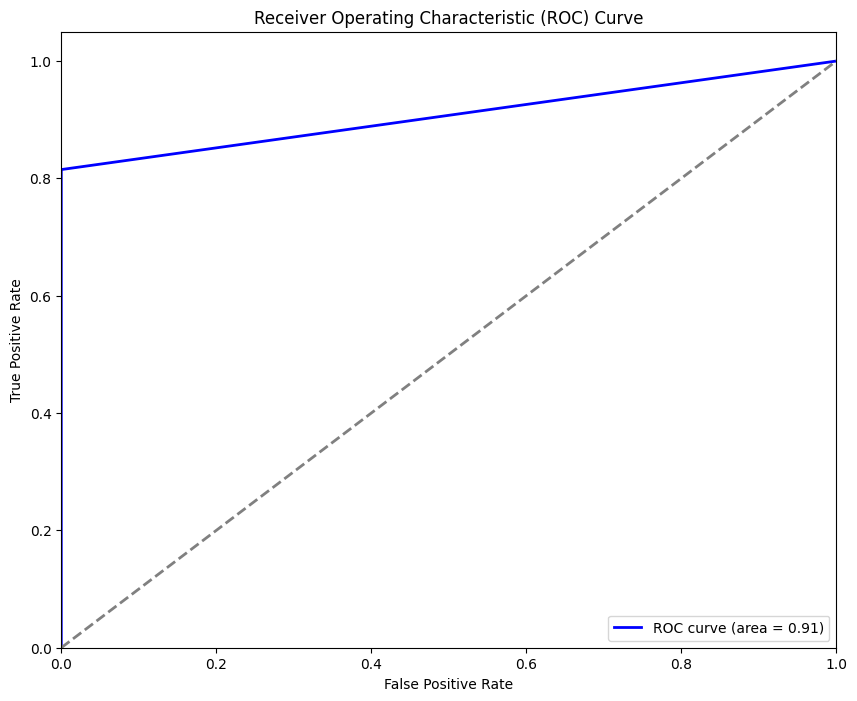

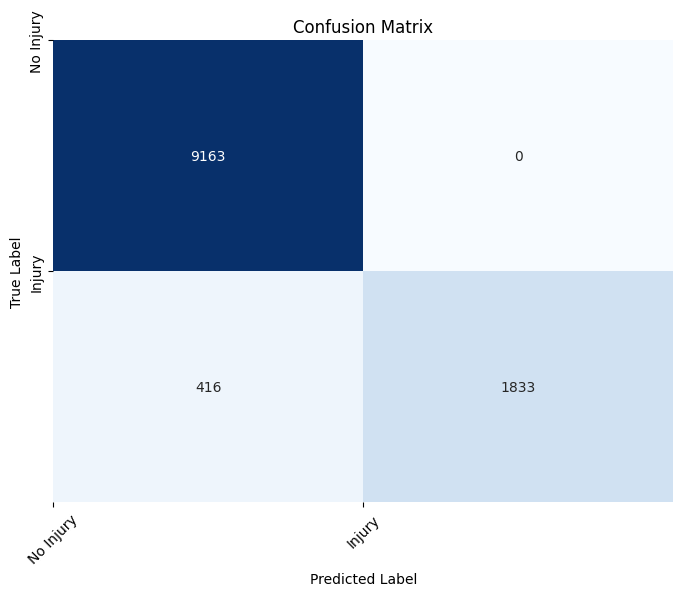

In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Load the test data
X_test_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/processed/X_test.csv'
y_test_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/processed/y_test.csv'

X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

# If y_test is loaded as a DataFrame, convert it to a Series
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()

# Available features in X_test
available_features = X_test.columns.tolist()
print("Available features in X_test:", available_features)

# Features expected by the model (excluding 'Recent_Injury')
expected_features = [
    'age', 'height', 'Mass', 'Gender', 'Dominance', 
    'Experience', 'SessionsPerWk', 'Treadmill', 'Grass', 
    'Trail', 'Volume', 'Pace', 'RaceDist', 'InjuryLoc', 
    'DiagnosticMed', 'ShoeSize', 'RFSI25', 'LFSI25', 
    'RHIPEXT'
]

# Filter out any features that are not present in the test data
best_features = [feature for feature in expected_features if feature in available_features]

# Ensure X_test contains only these features
X_test = X_test[best_features]

# Preprocess categorical columns in X_test
label_encoders = {}
for column in X_test.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X_test[column] = label_encoders[column].fit_transform(X_test[column].astype(str))

# Load the trained model using XGBoost's native method
model_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/final_xgboost_model_best_20_features.pkl'
model = xgb.Booster()
model.load_model(model_path)

# Adjust the feature names of the model to match those of X_test
model.feature_names = best_features

# Make predictions on the test set
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)
y_pred = np.round(y_pred)  # Since predict returns probabilities, round them to get binary predictions
y_pred_proba = y_pred  # Use the raw output as the probability

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Define tick_marks for the axis labels
tick_marks = np.arange(len(['No Injury', 'Injury']))
plt.xticks(tick_marks, ['No Injury', 'Injury'], rotation=45)
plt.yticks(tick_marks, ['No Injury', 'Injury'])
plt.show()


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# Load the data
data_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/processed/engineered_data.csv'
data = pd.read_csv(data_path)

# Prepare features and target
X = data[best_features]
y = data['Injury']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)

# Set up the grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Perform the grid search on the resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_score}")

# Train the final model with the best parameters on the resampled training data
final_model = xgb.XGBClassifier(**best_params, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)

# Save the final model
model_output_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/final_xgboost_model_without_recent_injury.pkl'
final_model.save_model(model_output_path)
print(f"Final model saved to {model_output_path}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:18:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.8977586806794812


c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:18:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final model saved to D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/final_xgboost_model_without_recent_injury.pkl


c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:18:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [35]:
# Ensure the feature list matches between training and test data
if 'Recent_Injury' not in X_test.columns:
    X_test['Recent_Injury'] = 0  # or some appropriate value

# Proceed with predictions
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f'Test Classification Report:\n{classification_report(y_test, y_pred)}')


Accuracy: 0.9635
Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9163
           1       1.00      0.82      0.90      2249

    accuracy                           0.96     11412
   macro avg       0.98      0.91      0.94     11412
weighted avg       0.97      0.96      0.96     11412



In [26]:
# Remove `Recent_Injury` from the list of features used in prediction
best_features = [feature for feature in best_features if feature != 'Recent_Injury']


Cross validation


In [40]:
import pandas as pd
import joblib
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Load the merged and processed dataset
data_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/processed/merged_data.csv'
data = pd.read_csv(data_path)

# Encode categorical columns
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Separate features and target
X = data.drop(columns=['Injury'])
y = data['Injury']

# Load the trained model using joblib
model_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/final_xgboost_model.pkl'
model = joblib.load(model_path)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Perform cross-validation for each metric and print results
for metric_name, scorer in scoring_metrics.items():
    cv_results = cross_val_score(model, X, y, cv=cv, scoring=scorer)
    print(f"Cross-Validation {metric_name.capitalize()} Scores: {cv_results}")
    print(f"Mean Cross-Validation {metric_name.capitalize()}: {cv_results.mean():.4f}\n")


Cross-Validation Accuracy Scores: [0.99947424 1.         0.99947419 0.99991237 0.99938656]
Mean Cross-Validation Accuracy: 0.9996

Cross-Validation Precision Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Precision: 1.0000

Cross-Validation Recall Scores: [0.99735799 1.         0.99735683 0.99955947 0.99691766]
Mean Cross-Validation Recall: 0.9982

Cross-Validation F1 Scores: [0.99867725 1.         0.99867667 0.99977969 0.99845645]
Mean Cross-Validation F1: 0.9991

Cross-Validation Roc_auc Scores: [0.998679   1.         0.99867841 0.99977974 0.99845883]
Mean Cross-Validation Roc_auc: 0.9991



Mean Cross-Validation Accuracy: 0.9996
Mean Cross-Validation Precision: 1.0000
Mean Cross-Validation Recall: 0.9982
Mean Cross-Validation F1: 0.9991
Mean Cross-Validation ROC-AUC: 0.9991


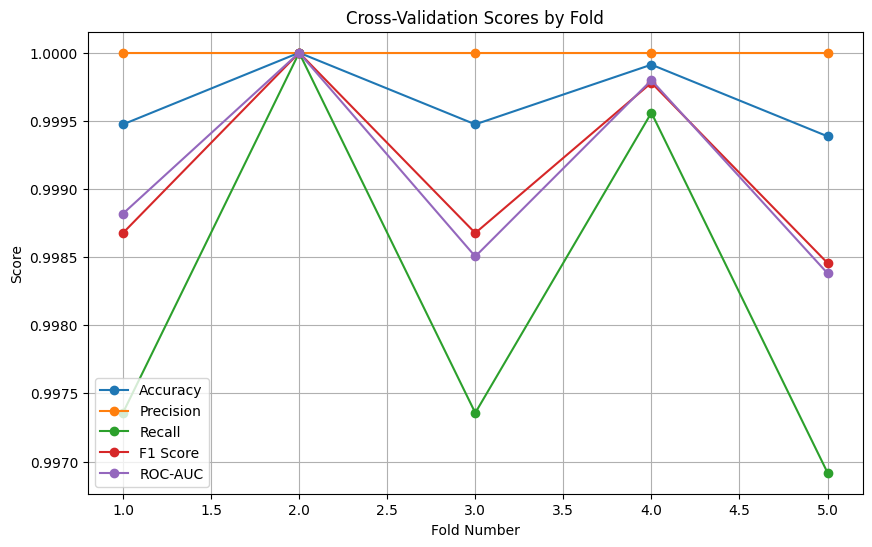

In [41]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold

# Assuming 'model', 'X', and 'y' are already defined and preprocessed

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Perform cross-validation and get all scores at once
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

# Print the mean scores
print(f"Mean Cross-Validation Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Cross-Validation Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Mean Cross-Validation Recall: {cv_results['test_recall'].mean():.4f}")
print(f"Mean Cross-Validation F1: {cv_results['test_f1'].mean():.4f}")
print(f"Mean Cross-Validation ROC-AUC: {cv_results['test_roc_auc'].mean():.4f}")

# Plotting the cross-validation scores for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, cv.get_n_splits() + 1), cv_results['test_accuracy'], marker='o', label='Accuracy')
plt.plot(range(1, cv.get_n_splits() + 1), cv_results['test_precision'], marker='o', label='Precision')
plt.plot(range(1, cv.get_n_splits() + 1), cv_results['test_recall'], marker='o', label='Recall')
plt.plot(range(1, cv.get_n_splits() + 1), cv_results['test_f1'], marker='o', label='F1 Score')
plt.plot(range(1, cv.get_n_splits() + 1), cv_results['test_roc_auc'], marker='o', label='ROC-AUC')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.legend()
plt.title('Cross-Validation Scores by Fold')
plt.grid(True)
plt.show()


In [11]:
from sklearn.model_selection import train_test_split

# Assume X and y are your features and target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


[0]	train-logloss:0.41813	eval-logloss:0.41625
[10]	train-logloss:0.13890	eval-logloss:0.13760
[20]	train-logloss:0.05400	eval-logloss:0.05358
[30]	train-logloss:0.02471	eval-logloss:0.02460
[40]	train-logloss:0.01153	eval-logloss:0.01170
[50]	train-logloss:0.00710	eval-logloss:0.00759
[60]	train-logloss:0.00473	eval-logloss:0.00568
[70]	train-logloss:0.00363	eval-logloss:0.00509
[80]	train-logloss:0.00295	eval-logloss:0.00480
[90]	train-logloss:0.00249	eval-logloss:0.00478
[96]	train-logloss:0.00229	eval-logloss:0.00482


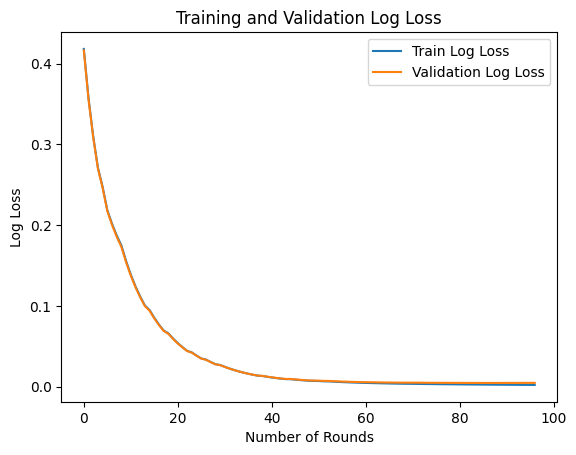

Validation Accuracy: 0.9995
Validation Log Loss: 0.0048


In [43]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your full dataset of features and labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you can proceed with the rest of the code
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set up parameters and evaluation metric
params = {
    'objective': 'binary:logistic',  # for binary classification
    'eval_metric': 'logloss',         # log loss is a good choice for binary classification
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,            # minimum sum of instance weight (hessian) needed in a child
    'subsample': 0.8,                 # fraction of samples to be used for each tree
    'colsample_bytree': 0.8,          # fraction of features to be used for each tree
    'seed': 42,
    'lambda': 1,                      # L2 regularization term on weights
    'alpha': 0,                       # L1 regularization term on weights
}

# Train the model with a validation set
evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=100, 
    evals=evals, 
    evals_result=evals_result,
    early_stopping_rounds=10,  # Stops if validation metric doesn't improve
    verbose_eval=10            # Print log every 10 rounds
)

# Save the model if necessary
model.save_model('xgboost_model.json')

# Extract evaluation results
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['eval']['logloss']

# Optional: Plot the training and validation log loss
import matplotlib.pyplot as plt

plt.plot(train_logloss, label='Train Log Loss')
plt.plot(val_logloss, label='Validation Log Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('Log Loss')
plt.title('Training and Validation Log Loss')
plt.legend()
plt.show()

# Predict on validation set
y_pred = model.predict(dval)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate model performance
from sklearn.metrics import accuracy_score, log_loss

accuracy = accuracy_score(y_val, y_pred_binary)
logloss = log_loss(y_val, y_pred)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {logloss:.4f}')


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

# Load your dataset
data_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/processed/merged_data.csv'
data = pd.read_csv(data_path)

# Encode categorical columns to numeric values
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Assuming 'Injury' is the target variable
X = data.drop(columns=['Injury'])
y = data['Injury']

# Ensure that there are two unique classes in the target
print("Unique classes in the target variable:", y.unique())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Manually perform grid search with early stopping
best_model = None
best_score = 0
best_params = None

for params in ParameterGrid(param_grid):
    model = XGBClassifier(**params, eval_metric='logloss', use_label_encoder=False)
    
    # Fit model with early stopping using `eval_set` and monitoring
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_score}")

# Save the final model
model_output_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/final_xgboost_model_best_20_features.pkl'
joblib.dump(best_model, model_output_path)
print(f"Final model saved to {model_output_path}")

# Evaluate the final model on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')


Unique classes in the target variable: [0 1]


c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:07:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_la

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Best Accuracy: 0.9994742376445847
Final model saved to D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/final_xgboost_model_best_20_features.pkl
Accuracy: 0.9995
Precision: 1.0000
Recall: 0.9973
F1-Score: 0.9987
AUC-ROC: 0.9991


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

# Load your dataset
data_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/processed/merged_data.csv'
data = pd.read_csv(data_path)

# Encode categorical columns to numeric values
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Assuming 'Injury' is the target variable
X = data.drop(columns=['Injury'])
y = data['Injury']

# Ensure that there are two unique classes in the target
print("Unique classes in the target variable:", y.unique())

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Manually perform grid search without early stopping
best_model = None
best_score = 0
best_params = None

for params in ParameterGrid(param_grid):
    model = XGBClassifier(**params, use_label_encoder=False)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    score = accuracy_score(y_val, y_val_pred)
    
    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Save the best model
model_output_path = 'D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/final_xgboost_model_best_params.pkl'
joblib.dump(best_model, model_output_path)
print(f"Best model saved to {model_output_path}")

# Evaluate the final model on the validation set
y_test_pred = best_model.predict(X_val)
y_test_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate performance metrics on the validation set
accuracy = accuracy_score(y_val, y_test_pred)
precision = precision_score(y_val, y_test_pred)
recall = recall_score(y_val, y_test_pred)
f1 = f1_score(y_val, y_test_pred)
roc_auc = roc_auc_score(y_val, y_test_proba)

# Print the results
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-Score: {f1:.4f}')
print(f'Validation AUC-ROC: {roc_auc:.4f}')


Unique classes in the target variable: [0 1]


c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Neethiarasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_la

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Best Validation Accuracy: 0.9995
Best model saved to D:/Data science classes slides pdf/Football_analysis/football_analytics_injury_prevention/models/final_xgboost_model_best_params.pkl
Validation Accuracy: 0.9995
Validation Precision: 1.0000
Validation Recall: 0.9973
Validation F1-Score: 0.9987
Validation AUC-ROC: 0.9991


In [49]:
from sklearn.metrics import confusion_matrix

# Assuming y_pred contains probabilities, convert them to binary labels
# For example, using a threshold of 0.5
y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Unravel the confusion matrix to get the individual counts
tn, fp, fn, tp = conf_matrix.ravel()

# Print out the confusion matrix values with labels for clarity
print(f"Confusion Matrix:")
print(conf_matrix)
print("\n")

# Print out the individual components of the confusion matrix
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# Optionally, you can also calculate and print additional performance metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[9163    0]
 [   6 2243]]


True Positives (TP): 2243
True Negatives (TN): 9163
False Positives (FP): 0
False Negatives (FN): 6

Additional Metrics:
Accuracy: 0.9995
Precision: 1.0000
Recall: 0.9973
F1 Score: 0.9987
